In [1]:
from diffusion.datasets import build_streaming_laion_dataloader
from diffusion.models.imagen import build_imagen
import matplotlib.pyplot as plt
from streaming.base.util import clean_stale_shared_memory
import torch
clean_stale_shared_memory()

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Configure streaming dataset, check a batch

In [2]:
remote = 'oci://mosaicml-internal-dataset-laion2b-en/4.5v2/64-128/1'

local = '/tmp/mds-cache/mds-laion2b-en/4.5v2/64-128/1'
tokenizer = 't5'
tokenizer_name_or_path = "google/t5-v1_1-base"

dataloader = build_streaming_laion_dataloader(remote=remote, local=local, tokenizer=tokenizer, tokenizer_name_or_path=tokenizer_name_or_path, batch_size=16, resize_size=64)
batch = dataloader.dataset[0]

## Setup Base Model

In [3]:
base_model = build_imagen(t5_name="google/t5-v1_1-base", stage=2)
base_model.to('cuda');

In [4]:
base_model.model.forward??

Signature:
base_model.model.forward(
    x,
    time,
    *,
    lowres_cond_img=None,
    lowres_noise_times=None,
    text_embeds=None,
    text_mask=None,
    cond_images=None,
    self_cond=None,
    cond_drop_prob=0.0,
)
Docstring:
Defines the computation performed at every call.

Should be overridden by all subclasses.

.. note::
    Although the recipe for forward pass needs to be defined within
    this function, one should call the :class:`Module` instance afterwards
    instead of this since the former takes care of running the
    registered hooks while the latter silently ignores them.
Source:   
    def forward(
        self,
        x,
        time,
        *,
        lowres_cond_img = None,
        lowres_noise_times = None,
        text_embeds = None,
        text_mask = None,
        cond_images = None,
        self_cond = None,
        cond_drop_prob = 0.
    ):
        batch_size, device = x.shape[0], x.device

        # condition on self

        if self.self_cond:


In [8]:
out = base_model.generate(prompt='a cat', guidance_scale=1, lowres_conditional_images=torch.randn(size=(1, 3, 64, 64)))
out.shape

  0%|          | 0/50 [00:00<?, ?it/s]


TypeError: Unet.forward() got an unexpected keyword argument 'lowres_aug_time'

## Check fwd pass

In [22]:
prompt = 'a cat'
negative_prompt = None

guidance_scale = 3
tokenized_prompts = None
prompt_embeds = None
num_images_per_prompt = 1
tokenized_negative_prompts = None
negative_prompt_embeds = None
height = 64
width = 64
device = 'cuda'
num_inference_steps = 5
lowres_conditional_images = None
progress_bar = True

from diffusion.models.imagen import resize_image_to
from tqdm.auto import tqdm

In [24]:
do_classifier_free_guidance = guidance_scale > 1.0  # type: ignore

text_embeddings = base_model._prepare_text_embeddings(prompt, tokenized_prompts, prompt_embeds, num_images_per_prompt)
batch_size = len(text_embeddings)  # len prompts * num_images_per_prompt
# classifier free guidance + negative prompts
# negative prompt is given in place of the unconditional input in classifier free guidance
if do_classifier_free_guidance:
    negative_prompt = negative_prompt or ([''] * (batch_size // num_images_per_prompt))  # type: ignore
    unconditional_embeddings = base_model._prepare_text_embeddings(negative_prompt, tokenized_negative_prompts,
                                                                negative_prompt_embeds, num_images_per_prompt)
    # concat uncond + prompt
    text_embeddings = torch.cat([unconditional_embeddings, text_embeddings])

# prepare for diffusion generation process
images = torch.randn((batch_size, 3, height, width), device=device)

base_model.inference_scheduler.set_timesteps(num_inference_steps)
# scale the initial noise by the standard deviation required by the scheduler
images = images * base_model.inference_scheduler.init_noise_sigma


lowres_aug_timesteps = None

# Forward through the model
if base_model.is_superres:
    # resize lowres image to same 
    lowres_conditional_images = resize_image_to(lowres_conditional_images, images.shape[-1], pad_mode='reflect')

    # add noise augmentation here, we add noise at a fixed timestep in the scheduler. 
    # for a scheduler with 1k steps and a noise level of 0.2 we would set the timestep to 200.
    lowres_aug_timesteps = torch.full((batch_size,), 
                                        int(len(base_model.scheduler) * base_model.noise_augmentation_level), 
                                        device=images.device, dtype=torch.long)
    lowres_noise = torch.randn_like(lowres_conditional_images)
    lowres_conditional_images = base_model.scheduler.add_noise(lowres_conditional_images, lowres_noise, lowres_aug_timesteps)

# backward diffusion process
timesteps = base_model.inference_scheduler.timesteps.to(device)
for t in tqdm(base_model.inference_scheduler.timesteps, disable=not progress_bar):
    timestep = t.unsqueeze(0).to(device)
    if do_classifier_free_guidance:
        model_input = torch.cat([images] * 2)
        timestep = torch.cat([timestep] * 2)
        if base_model.is_superres:
            lowres_conditional_images = torch.cat([lowres_conditional_images] * 2)
    else:
        model_input = images

    model_input = base_model.inference_scheduler.scale_model_input(model_input, t)
    # get model's predicted output
    if base_model.is_superres:
        model_output = base_model.model(x=model_input, time=timestep, text_embeds=text_embeddings,
                        lowres_cond_img=lowres_conditional_images, lowres_aug_time=lowres_aug_timesteps)
    else:
        model_output = base_model.model(x=model_input, time=timestep, text_embeds=text_embeddings)

    if do_classifier_free_guidance:
        # perform guidance. Note this is only techincally correct for prediction_type 'epsilon'
        pred_uncond, pred_text = model_output.chunk(2)
        model_output = pred_uncond + guidance_scale * (pred_text - pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    images = base_model.inference_scheduler.step(model_output, t, images)['prev_sample']

# Rescale to (0, 1)
images = (images / 2 + 0.5).clamp(0, 1)
images = images.detach()  # (batch*num_images_per_prompt, channel, h, w)

 40%|████      | 2/5 [00:00<00:00, 16.49it/s]

100%|██████████| 5/5 [00:00<00:00, 15.86it/s]


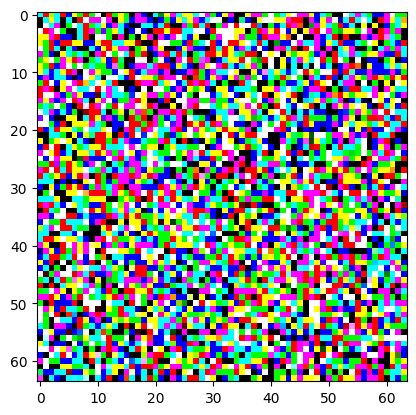

In [11]:
plt.imshow(images[0].permute(1, 2, 0).to('cpu'))

In [31]:
base_model.inference_scheduler.timesteps[0].unsqueeze(0).shape

torch.Size([1])

In [ ]:
base_model.model()

In [4]:
batch.keys()

dict_keys(['image', 'captions'])

In [5]:
batch['image'] = batch['image'].to('cuda')
batch['captions'] = batch['captions'].to('cuda');

In [6]:
next(base_model.text_encoder.parameters()).device

device(type='cuda', index=0)

In [17]:
inputs, conditioning = batch['image'], batch['captions'] # inputs are images 64,64

conditioning = base_model.text_encoder(input_ids=batch['captions'])[0] # embedding ([1, 512, 768]) b, maxlen, embbed_dim

timesteps = torch.randint(0,
                            len(base_model.scheduler), (1,),
                            device=inputs.device)
        # Add noise to the inputs (forward diffusion)
noise = torch.randn_like(inputs)
noised_inputs = base_model.scheduler.add_noise(inputs, noise, timesteps)

In [33]:
conditioning[0].shape

torch.Size([512, 768])

In [19]:
noised_inputs.shape

torch.Size([3, 64, 64])

In [21]:
conditioning.shape

torch.Size([1, 512, 768])

In [27]:
noised_inputs.shape, timesteps.shape, conditioning.shape

(torch.Size([3, 64, 64]), torch.Size([1]), torch.Size([1, 512, 768]))

In [29]:
out = base_model.model(x=noised_inputs.unsqueeze(0), time=timesteps)

In [11]:
tokenized = base_model._prepare_text_embeddings(prompt='a cat', tokenized_prompts=None, prompt_embeds=None, num_images_per_prompt=1)

In [10]:
batch = dataset.dataset[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


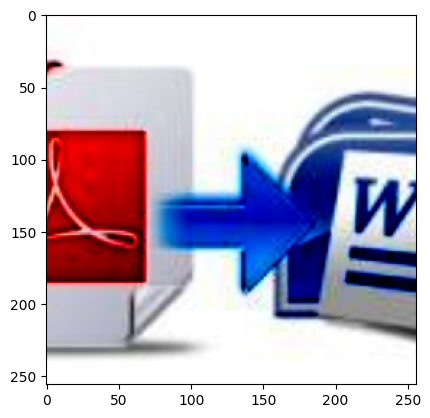

In [15]:
plt.imshow(batch['image'].permute(1, 2 ,0))

In [21]:
batch.keys()

dict_keys(['image', 'captions'])

In [22]:
batch['captions']

tensor([[ 9210,    18,   235,    18,  6051,    18,  1018,  3027,    49,    18,
          1161,    18, 11101,     1,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [27]:
out = base_model.text_encoder(input_ids=batch['captions'].to('cuda'))

In [31]:
out[0].shape

torch.Size([1, 512, 768])

In [14]:
tokenized.shape

torch.Size([1, 512, 768])

In [7]:
base_model.generate(prompt='a cat')

NameError: name 'base_model' is not defined

In [1]:
from composer.optim import CosineAnnealingWithWarmupScheduler

/usr/lib/python3/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
scheduler = CosineAnnealingWithWarmupScheduler(t_warmup='10_000ba', t_max='600_000ba')